# word embedding method

In [1]:
from konlpy.tag import Twitter
import math
import numpy as np

def load_file(filesrc):
        f = open(filesrc, 'rt', encoding='utf-16')
#         name = ""
        talk = []
#         speak = {}
        not_person = ['al', 'ot']
        talk_all = []
        while(True):
            data = f.readline() 
            if not data: break
    
            if("<u who=" in data or "<s n=" in data):
                # 발화자 구분
#                 if "who" in data:
#                     name = data[8:10]
#                     if name in not_person:
#                         continue
#                     if not (name in speak):
#                        speak[name] = [] 
    
                # 대화 추출
                temp = data.split(">")
                s = ""
                for v in temp:
                    idx = v.find('<')
                    if idx < 2: continue
#                     speak[name].append(v[:idx])
                    talk_all.append(v[:idx])
    
        return _,talk_all

def words_join(words,doc_index):
    word_idx = []
    doc_count = 0
    for index,lines in enumerate(words):
        if len(doc_index) > doc_count and index >= doc_index[doc_count]:
            doc_count += 1
        word_idx += [[v,index,doc_count] for v in lines.split(' ')]

    return np.array(word_idx)

def postaging(docs):
    twitter=Twitter()
    want = ['Exclamation','Adverb','Noun','Alpha','Verb','Adjective']
    stopword = ['어어','넷','만','것','타','최','태','개','홈','선','끼','각','번','하다','음','화', '이다',' ','다','더','포','제','저','여기','고','씬','첨','난','면','으루','네']
    pos = []
#     pos = ""

    for lines in docs:
        strs=""
        for t in twitter.pos(lines, norm=True, stem=True):
            if (t[1] in want) and (t[0] not in stopword) and(len(t[0]) > 1):
#             if (t[0] not in stopword) and len(t[0]) > 1:
#                 pos = pos + " " + t[0]
                pos.append(t[0])
#                 strs = strs + " " + t[0]
#         if strs[1:]:
#             pos.append(strs[1:])

    return pos



def words_join(words,doc_index):
        word_idx = []
        doc_count = 0
        for index,lines in enumerate(words):
            if len(doc_index) > doc_count and index >= doc_index[doc_count]:
                doc_count += 1
            word_idx += [[v,index,doc_count] for v in lines.split(' ')]
            
        return np.array(word_idx)

# 그냥 많은 데이터로 테스트

In [127]:
# load_list = ["7CM00055.txt","4CM00094.txt","6CM00079.txt","6CM00080.txt","6CM00082.txt","6CM00083.txt","6CM00088.txt","6CM00090.txt","6CM00092.txt","6CM00093.txt","6CM00094.txt","6CM00095.txt"]
load_list =  ["6CM00082-정치.txt","6CM00096-외국어시험.txt"]
talk_list = []
speak_list = []
doc_index = []
word_list = []

#load는 리스트 형태  , 한번에 여러문서도가능하도록 --> 나중에는 db형식으로 교체 필요
for path in load_list:
    _,talks = load_file(path)
    talk_list= talk_list + talks
    doc_index.append(len(talk_list)-1)
    # 포스테깅 및 stopword 처리 
    word_list.append(postaging(talk_list))


In [128]:
from gensim.models import Word2Vec
embedding_model = Word2Vec(word_list, size=50, window = 5, min_count=1, workers=4, iter=100, sg=1)

In [129]:
embedding_model.save("word2vec.model")

In [148]:
# from gensim.test.utils import common_texts
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(word_list)]
# model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [130]:
model = Word2Vec.load("word2vec.model")
# key is word list 
# model.wv.vocab    

# 클러스터링 임베딩 작업

In [131]:
#비교할 데이터 로드
load_list =  ["6CM00082-정치.txt","6CM00096-외국어시험.txt"]
talk_list = []
speak_list = []
doc_index = []

#load는 리스트 형태  , 한번에 여러문서도가능하도록 --> 나중에는 db형식으로 교체 필요
for path in load_list:
    _,talks = load_file(path)
    talk_list= talk_list + talks
    doc_index.append(len(talk_list)-1)

print("doc_index : ",doc_index)
# 포스테깅 및 stopword 처리 
word_list = postaging(talk_list)
print(len(word_list))
words = words_join(word_list,doc_index)

# print(words[:29])

doc_index :  [531, 1397]
3232


In [142]:
term = 30
doc_size = 200
cluster_word = []
vector_size = 50
cluster_word_vector = []
# doc_size 만큼 join
cluster_word_vector = [np.array(words[index:index+doc_size])[:,[0]]  for index in range(0,len(words),term) if index + doc_size < len(words)]
# word  -> vector 
cluster_word_vector = [[model.wv[word[0]] for word in docs if word[0] in model.wv.vocab] for docs in cluster_word_vector]
# fatten use when using pca
# cluster_word_vector = [np.array(words).flatten() for words in cluster_word_vector]

## Dimension reduction 1- pca (not use)

In [68]:
from sklearn import cluster
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA

In [138]:
ipca = IncrementalPCA(batch_size=3, copy=True, n_components=100, whiten=False)
pca_vector = ipca.fit_transform(cluster_word_vector)

E:\conda\lib\site-packages\sklearn\decomposition\incremental_pca.py:261: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
C:\Users\suhyun\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Number of input features has changed from 3 to 99 between calls to partial_fit! Try setting n_components to a fixed value.

## cosine_similarity By each word index

In [161]:
from sklearn.metrics.pairwise import cosine_similarity
# len(cluster_word_vector[0])
cluster_word_similarity = [cosine_similarity(cluster_word_vector[words_index],cluster_word_vector[words_index+1])  for words_index in range(len(cluster_word_vector)) if word_index < len(cluster_word_vector) - 2]
# a= [[1,1],[3,2]]
# b = [[1,1],[3,3]]
# cosine_similarity(a,b)
# cluster_word_vector[0]

NameError: name 'word_index' is not defined

In [157]:
a= [[1,1],[3,2]]
b = [[1,1],[3,3]]
cosine_similarity(a,b)

array([[1.        , 1.        ],
       [0.98058068, 0.98058068]])

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
cluster_word_similarity =  cosine_similarity(cluster_word_vector,cluster_word_vector)
test = [v[i+1:i+2] for i,v in enumerate(cluster_word_similarity)]

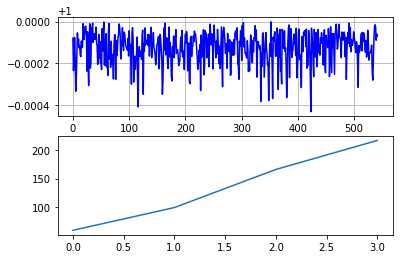

[59, 99, 166, 217]

In [85]:
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inlince
# words_chart = [words[i] for i in  range(0,len(test),term) if i+doc_size < len(words)]
# words_chart = np.array(words_chart)
# print(words_chart.shape)
# print(type(words_chart[1]))
# print(words_chart[:])
doc_slide = [int((len(index[0])-150)/term) for index in documents]
# doc_slide = [doc_slide[i-1]+v if i != 0 else v for i,v in enumerate(doc_slide) ]
flg = plt.figure()
x1 = flg.add_subplot(2, 1, 1)

x1.plot(test[:-1],color='blue')
x1.grid(True)

x2 = flg.add_subplot(2, 1, 2)
x2.plot(doc_slide)
# x2.plot(words_chart[:,[2]])
# plt.figure(figsize=(30, 20))
plt.show()

doc_slide

# 군집수 분석

### 클러스터링1

In [83]:
def cluster_boundary1(similarity,repeat,min,cluster_value,term):
    index=[]
    sim = similarity[:]
    #repeat 만큼 반복해서 걸러내기
    for rpt in range(repeat):
        sim.sort()
        # min%만큼 낮은값만 뽑아내는 작업
        index = [similarity.index(i) for i in sim[:int(len(sim)*(min/100))]]
        sim = [similarity[i] for i in index]
    
    index.sort()
    # 가까이있는값은 하나로 묶기 (cluster_value)
    indexing = [v  for i,v in enumerate(index) if (v-index[i-1])/len(similarity) > cluster_value]
#     print(index)
#     print(indexing)
#     print(len(similarity))
    
    #노이즈로 생각되는값 뽑기

    # 노이즈 체크 공식 (suhyuns-sim) 전체길이  * min 퍼센트 ^ repeat 수
    # term 으로 체크시 뒤에 노이즈범위 값안에 들어가는만큼 노이즈 count 증가 이걸 noise_check로 비율 넣기
    noise_check = int(math.sqrt(len(similarity)*pow((min/100),2)))
#     print(noise_check)
#     print(index)
    noise_count = []
    for i in indexing:
        check = 0
        idx = index.index(i)
#         print(idx)
        while(True):
            if idx+check >= len(index)-1 or index[idx+check+1] - index[idx] > term:
                break
            check +=1
        noise_count.append(check/noise_check)
    
    return indexing,noise_count

#0에 가까울수록 클러스터 포인트 1넘으면 100% 아님으로보면될듯

cluster_boundary1(test[:-1],2,40,.04,term)

([104, 147, 532], [0.5555555555555556, 0.6666666666666666, 0.1111111111111111])

### 클러스터링2 최대최소 비율

In [84]:
def cluster_boundary2(similarity,repeat,min_rate,cluster_value,term):
    index=[]
    sim = similarity[:]
    #repeat 만큼 반복해서 걸러내기
    for rpt in range(repeat):
        #최대최소 안뽑혀서 일단 이걸로 ';;
#         sim.sort()
        min_value = min(sim)
        max_value = max(sim)
        #  max - (max-min)(1-min_ratio/100)
        compare_rate = max_value - (max_value-min_value)*(1-min_rate/100)
#         print("min :",min_value)
#         print("max :",max_value)
#         print("compare_rate :",compare_rate)
        
        # min%만큼 낮은값만 뽑아내는 작업
        index = [similarity.index(i) for i in sim if i< compare_rate]
        sim = [similarity[i] for i in index]
    
    index.sort()
    # 가까이있는값은 하나로 묶기 (cluster_value)
    indexing = [v  for i,v in enumerate(index) if (v-index[i-1])/len(similarity) > cluster_value or i+1 == len(index)]

    #노이즈로 생각되는값 뽑기
    # 노이즈 체크 공식 (suhyuns-sim) 전체길이  * min 퍼센트 ^ repeat 수
    # term 으로 체크시 뒤에 노이즈범위 값안에 들어가는만큼 노이즈 count 증가 이걸 noise_check로 비율 넣기
    
    noise_check = math.sqrt(len(similarity)*pow((min_rate/100),2))
#     print("noise_check : ",noise_check)
    noise_count = []
#     print("index : ",index)
#     print("indexing :",indexing)
    for i in indexing:
        check = 0
        idx = index.index(i)
#         print(idx)
        while(True):
            if idx+check >= len(index)-1 or index[idx+check+1] - index[idx] > term:
                break
            check +=1
        noise_count.append(check/noise_check)
    
    return indexing,noise_count

#0에 가까울수록 클러스터 포인트 1넘으면 100% 아님으로보면될듯

cluster_boundary2(test[:-1],2,40,.04,term)

([334, 380, 423], [0.21476838979377885, 0.0, 0.0])